Library to track time

In [3]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 


In [4]:
%load_ext autotime

time: 537 µs (started: 2022-08-24 15:51:39 +00:00)


Divide and Concur

In [5]:
from math import sqrt, floor
import numpy as np

def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """
    
    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.mat(np.zeros((k,n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m/k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shards)
    # Sum columns of shards, get means; these columnar means are centroids
    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

def _get_mean(sums, step):
    """
    Vectorizable ufunc for getting means of summed shard columns.
    
    Parameters
    ----------
    sums : float
        The summed shard columns.
    step : int
        The number of instances per shard.
    Returns
    -------
    sums/step (means) : numpy array
        The means of the shard columns.
    """

    return sums/step

time: 5.76 ms (started: 2022-08-24 15:51:42 +00:00)


Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

time: 3.5 ms (started: 2022-08-24 15:51:45 +00:00)


Data load

In [7]:
housing_df = pd.read_csv('https://github.com/sumit07041997/Thesis/blob/da27879288795d189088bed682cd4df5c8ebe512/housing.csv?raw=true')

housing_df.head

<bound method NDFrame.head of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  ho

time: 1.05 s (started: 2022-08-24 15:51:48 +00:00)


In [8]:
print(housing_df.isnull().values.any())

True
time: 14.9 ms (started: 2022-08-24 15:51:52 +00:00)


In [9]:
housing_df.dropna(inplace=True)

time: 31.8 ms (started: 2022-08-24 15:51:55 +00:00)


In [10]:
print(housing_df.isnull().values.any())

False
time: 9.49 ms (started: 2022-08-24 15:51:58 +00:00)


Number of classes and it's count

In [11]:
lable = housing_df['ocean_proximity'].copy()
data = housing_df.drop('ocean_proximity',axis=1)

lable.value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

time: 16.7 ms (started: 2022-08-24 15:52:00 +00:00)


Scaling

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data= scaler.fit_transform(data)

time: 13.6 ms (started: 2022-08-24 15:52:02 +00:00)


Elbow Method

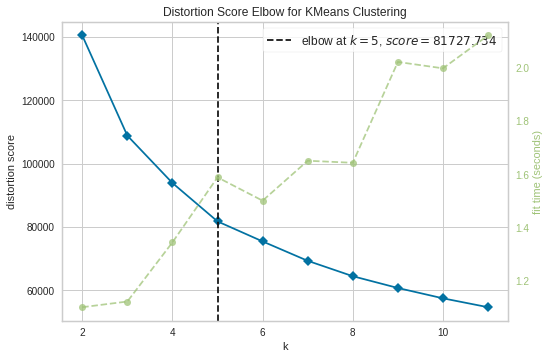

time: 16.9 s (started: 2022-08-24 15:52:05 +00:00)


In [13]:
from yellowbrick.cluster import KElbowVisualizer
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='distortion'
)
visualizer.fit(data)        
visualizer.show() 

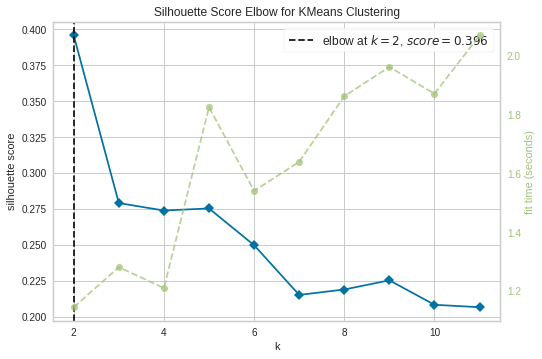

time: 1min 16s (started: 2022-08-24 15:52:51 +00:00)


In [14]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='silhouette')
visualizer.fit(data) 
visualizer.show() 


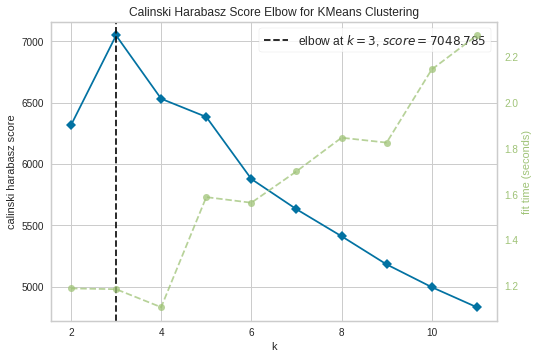

time: 16.9 s (started: 2022-08-24 15:59:33 +00:00)


In [15]:
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz')
visualizer.fit(data) 
visualizer.show()

Time comparison on K-means++, random and divide

In [18]:
kmeans = KMeans(n_clusters=5,init='random', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  47
time: 6.51 s (started: 2022-08-24 16:00:09 +00:00)


In [19]:
kmeans = KMeans(n_clusters=5,init='k-means++', random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  45
time: 3.83 s (started: 2022-08-24 16:00:22 +00:00)


In [21]:
kmeans = KMeans(n_clusters=5,init=naive_sharding(data,5), random_state=0).fit(data)
print('Iterations: ',kmeans.n_iter_)

Iterations:  86
time: 162 ms (started: 2022-08-24 16:00:46 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


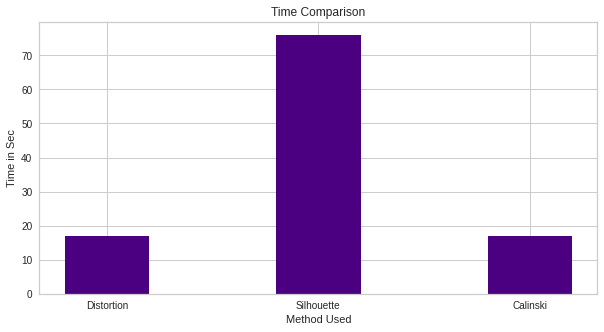

time: 166 ms (started: 2022-08-24 16:01:43 +00:00)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
 

method = ['Distortion','Silhouette','Calinski']
time = [17,76,17]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(method, time, color ='indigo',
        width = 0.4)
 
plt.xlabel("Method Used")
plt.ylabel("Time in Sec")
plt.title("Time Comparison")
plt.show()